Running in Colab: True
Please upload your CSV (e.g., imu6500_YYYYMMDD_HHMMSS.csv)


Saving imu6500_20251026_090451.csv to imu6500_20251026_090451.csv
Loaded: imu6500_20251026_090451.csv  shape=(3979, 8)
Columns: ['#HDR ms', 'ax', 'ay', 'az', 'mag', 'hp_abs', 'rms', 'label']

Counts by true label:
label
CALM       742
STRUCT     905
FOOT       465
PLAY      1285
JUMP       582
Name: count, dtype: int64

Counts by predicted label:
pred_label
CALM       742
STRUCT     905
FOOT       465
PLAY      1285
JUMP       582
Name: count, dtype: int64


<Figure size 960x600 with 0 Axes>

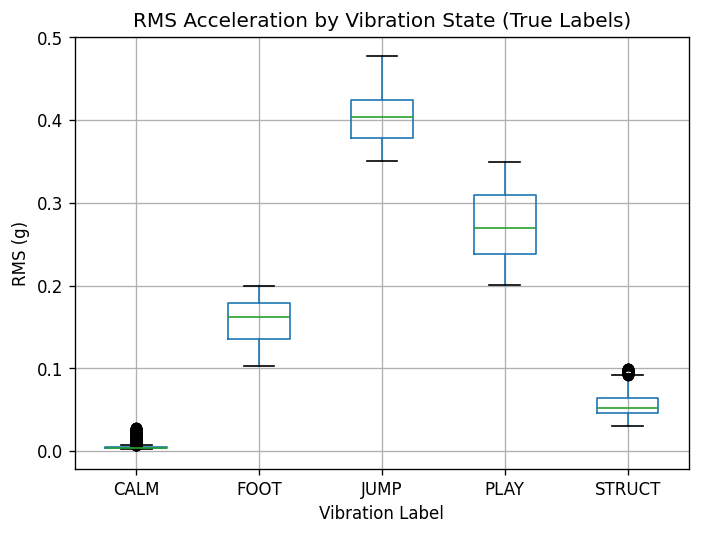

<Figure size 768x576 with 0 Axes>

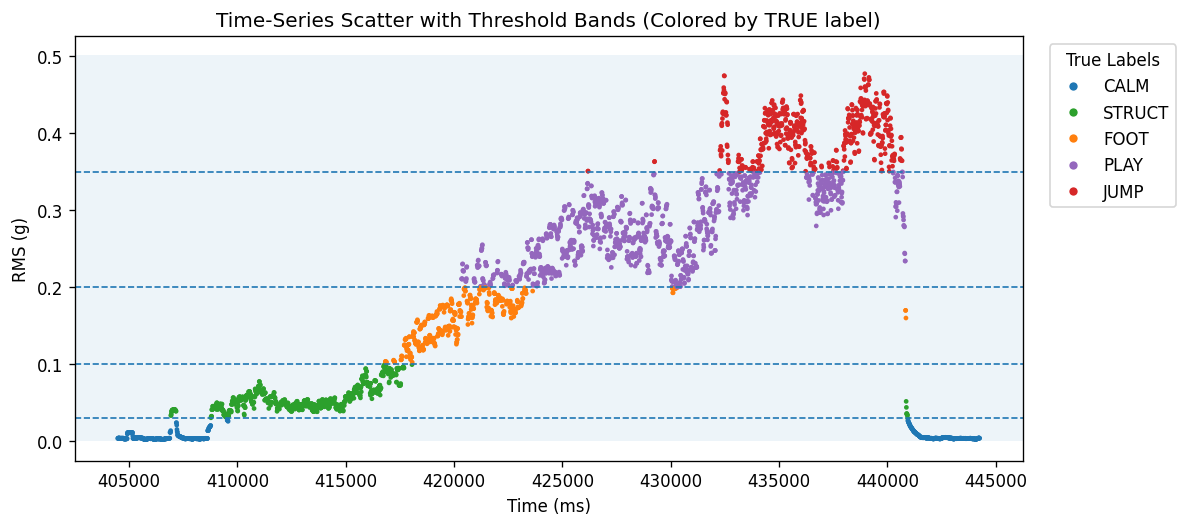

<Figure size 768x576 with 0 Axes>

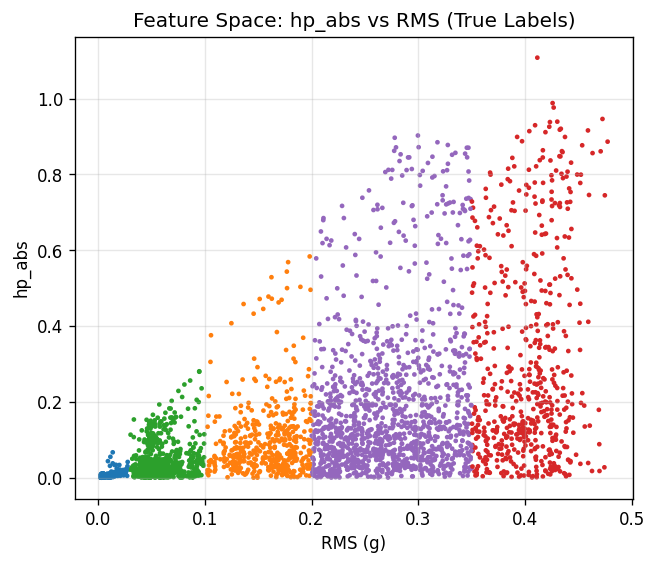

<Figure size 768x576 with 0 Axes>

<Figure size 624x540 with 0 Axes>

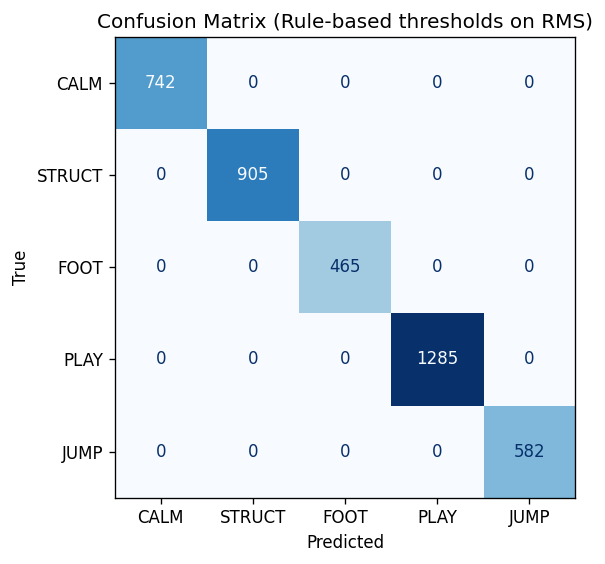


Classification Report (macro avg / weighted avg at bottom):
              precision    recall  f1-score   support

        CALM       1.00      1.00      1.00       742
      STRUCT       1.00      1.00      1.00       905
        FOOT       1.00      1.00      1.00       465
        PLAY       1.00      1.00      1.00      1285
        JUMP       1.00      1.00      1.00       582

    accuracy                           1.00      3979
   macro avg       1.00      1.00      1.00      3979
weighted avg       1.00      1.00      1.00      3979



rms                                    hp_abs                    \
            mean       std     min     max count      mean       std     min   
label                                                                          
CALM    0.005510  0.004517  0.0023  0.0279   742  0.004239  0.005744  0.0000   
FOOT    0.157681  0.025944  0.1025  0.1997   465  0.103673  0.102160  0.0002   
JUMP    0.401881  0.029333  0.3502  0.4772   582  0.309900  0.265882  0.0007   
PLAY    0.272924  0.042628  0.2002  0.3499  1285  0.193635  0.196365  0.0004   
STRUCT  0.056425  0.015402  0.0301  0.0996   905  0.039224  0.042393  0.0001   

                           mag                                  
           max count      mean       std     min     max count  
label                                                           
CALM    0.0669   742  1.015786  0.006637  0.9464  1.0725   742  
FOOT    0.5837   465  1.042612  0.146295  0.4367  1.3332   465  
JUMP    1.1082   582  1.047490  0.415904  0.1032  2.1609   582  
PLAY    0.9028  1285  1.020099  0.280845  0.0982  1.9386  1285  
STRUCT  0.2807   905  1.017685  0.058801  0.7266  1.2560   905

<Figure size 768x576 with 0 Axes>

In [ ]:
# ==============================================
# IMU6500 Vibration Classification – Colab Notebook
# Data classification plots + rule-based evaluation
# ==============================================

# 0) Setup
import io, sys, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Colab file upload helper
try:
    from google.colab import files  # will exist on Colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

print("Running in Colab:", IN_COLAB)

# 1) Load CSV
# --- Option A: Upload (Colab) ---
if IN_COLAB:
    print("Please upload your CSV (e.g., imu6500_YYYYMMDD_HHMMSS.csv)")
    up = files.upload()  # choose your file
    csv_name = list(up.keys())[0]
    df = pd.read_csv(io.BytesIO(up[csv_name]))
else:
    # --- Option B: Local path (edit as needed) ---
    csv_name = "imu6500_20251026_090451.csv"  # change if running locally
    df = pd.read_csv(csv_name)

print(f"Loaded: {csv_name}  shape={df.shape}")
print("Columns:", list(df.columns))

# 2) Basic cleaning / standardize column names
colmap = {c: c.strip().lower().replace("#", "").replace(" ", "_") for c in df.columns}
df.rename(columns=colmap, inplace=True)

# Minimal required columns
required = {"ax", "ay", "az", "mag", "hp_abs", "rms", "label"}
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}\nFound: {list(df.columns)}")

# Optional: rename ms column if present
if "hdr_ms" in df.columns and "ms" not in df.columns:
    df.rename(columns={"hdr_ms": "ms"}, inplace=True)
if "ms" not in df.columns:
    # If no timestamp, synthesize a sample index
    df["ms"] = np.arange(len(df)) * 10  # assume 100 Hz (10 ms); adjust if needed

# 3) Label order + thresholds (g)
LABELS = ["CALM", "STRUCT", "FOOT", "PLAY", "JUMP"]
df["label"] = df["label"].astype(str).str.upper().str.strip()

# Threshold bands (RMS in g) – update here if you recalibrate
THRESH = {
    "CALM_MAX": 0.03,   # < 0.03
    "STRUCT_MAX": 0.10, # [0.03, 0.10)
    "FOOT_MAX": 0.20,   # [0.10, 0.20)
    "PLAY_MAX": 0.35    # [0.20, 0.35)
    # JUMP: >= 0.35
}

def classify_by_rms(r):
    if r < THRESH["CALM_MAX"]:
        return "CALM"
    elif r < THRESH["STRUCT_MAX"]:
        return "STRUCT"
    elif r < THRESH["FOOT_MAX"]:
        return "FOOT"
    elif r < THRESH["PLAY_MAX"]:
        return "PLAY"
    else:
        return "JUMP"

df["pred_label"] = df["rms"].apply(classify_by_rms)

# 4) Quick summary
print("\nCounts by true label:")
print(df["label"].value_counts().reindex(LABELS))
print("\nCounts by predicted label:")
print(df["pred_label"].value_counts().reindex(LABELS))

# 5) PLOTS
plt.rcParams["figure.dpi"] = 120

# 5.1 Boxplot of RMS by TRUE label
plt.figure(figsize=(8,5))
order = [lab for lab in LABELS if lab in df["label"].unique()]
df.boxplot(column="rms", by="label", grid=True)
plt.title("RMS Acceleration by Vibration State (True Labels)")
plt.suptitle("")
plt.xlabel("Vibration Label")
plt.ylabel("RMS (g)")
plt.show()
plt.savefig("RMS Acceleration by Vibration State (True Labels).png", dpi=150)


# 5.2 Scatter: time vs RMS with threshold bands + true labels as colors
# Simple color map for labels
color_map = {
    "CALM":  "#1f77b4",
    "STRUCT":"#2ca02c",
    "FOOT":  "#ff7f0e",
    "PLAY":  "#9467bd",
    "JUMP":  "#d62728",
}
c = df["label"].map(color_map).fillna("#7f7f7f").values

plt.figure(figsize=(10,4.5))
ax = plt.gca()

# Threshold bands
ax.axhspan(0, THRESH["CALM_MAX"], alpha=0.08, label="CALM band")
ax.axhspan(THRESH["CALM_MAX"], THRESH["STRUCT_MAX"], alpha=0.08, label="STRUCT band")
ax.axhspan(THRESH["STRUCT_MAX"], THRESH["FOOT_MAX"], alpha=0.08, label="FOOT band")
ax.axhspan(THRESH["FOOT_MAX"], THRESH["PLAY_MAX"], alpha=0.08, label="PLAY band")
ax.axhspan(THRESH["PLAY_MAX"], df["rms"].max()*1.05, alpha=0.08, label="JUMP band")

# Scatter
plt.scatter(df["ms"], df["rms"], s=8, c=c, edgecolors="none")
plt.title("Time-Series Scatter with Threshold Bands (Colored by TRUE label)")
plt.xlabel("Time (ms)")
plt.ylabel("RMS (g)")

# Horizontal lines for quick reference
for y in [THRESH["CALM_MAX"], THRESH["STRUCT_MAX"], THRESH["FOOT_MAX"], THRESH["PLAY_MAX"]]:
    plt.axhline(y, linestyle="--", linewidth=1)

# Build a simple legend for labels
handles = [plt.Line2D([0],[0], marker='o', color='w', label=lab,
                      markerfacecolor=color_map[lab], markersize=6) for lab in LABELS]
plt.legend(handles=handles, title="True Labels", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()
plt.savefig("Time-Series Scatter with Threshold Bands (Colored by TRUE label).png", dpi=150)


# 5.3 Scatter: hp_abs vs RMS (true labels)
plt.figure(figsize=(6,5))
plt.scatter(df["rms"], df["hp_abs"], s=8, c=c, edgecolors="none")
plt.title("Feature Space: hp_abs vs RMS (True Labels)")
plt.xlabel("RMS (g)")
plt.ylabel("hp_abs")
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig("Feature Space: hp_abs vs RMS (True Labels).png", dpi=150)


# 6) Evaluation of rule-based classifier (thresholds) vs TRUE labels
y_true = df["label"].values
y_pred = df["pred_label"].values

# Restrict to labels present (and order them)
present_labels = [lab for lab in LABELS if lab in pd.unique(np.concatenate([y_true, y_pred]))]

cm = confusion_matrix(y_true, y_pred, labels=present_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)

plt.figure(figsize=(5.2,4.5))
disp.plot(values_format='d', cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (Rule-based thresholds on RMS)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
plt.savefig("Confusion Matrix (Rule-based thresholds on RMS).png", dpi=150)


print("\nClassification Report (macro avg / weighted avg at bottom):")
print(classification_report(y_true, y_pred, labels=present_labels, zero_division=0))


# 7) Per-label descriptive stats table (for report)
group_stats = df.groupby("label")[["rms","hp_abs","mag"]].agg(["mean","std","min","max","count"])
display(group_stats)

